In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/Apple",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 9714 files belonging to 4 classes.


In [7]:
class_names=dataset.class_names

In [8]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [9]:
len(dataset)

304

In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 2 0 3 0 0 2 0 0 1 0 1 1 1 1 2 2 3 3 1 1 1 0 1 3 2 2 1 1 0 2]


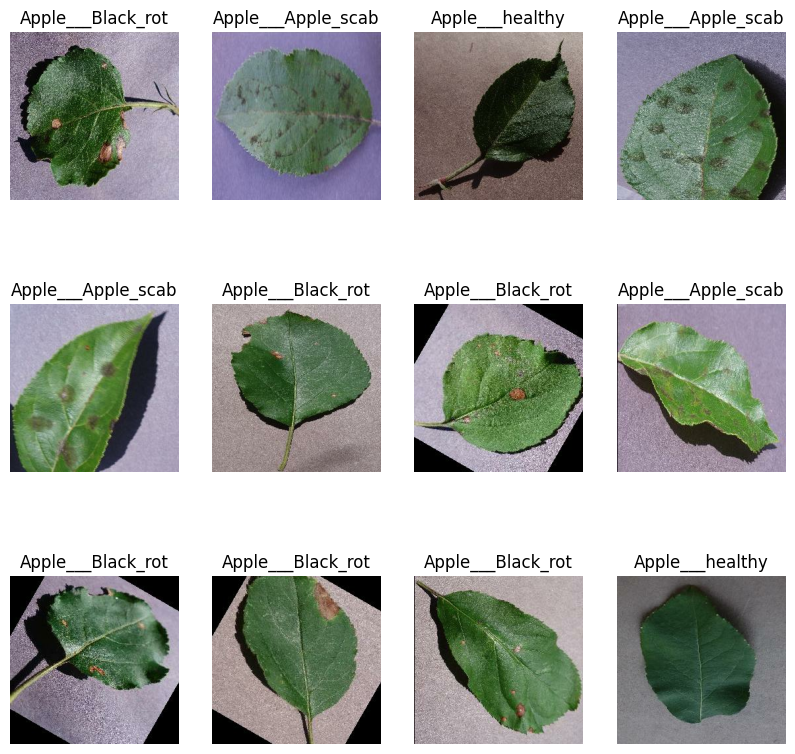

In [11]:
plt.figure (figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### Train Test Validate Split

In [12]:
def train_test_valid_split(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(len(ds)*train_split)
    test_size=int(len(ds)*test_split)
    
    train_apl=dataset.take(train_size)
    temp_apl=dataset.skip(train_size)
    test_apl=temp_apl.take(test_size)
    val_apl=temp_apl.skip(test_size)
    return train_apl,test_apl,val_apl


In [13]:
train_apl,test_apl,val_apl=train_test_valid_split(dataset)

In [14]:
print(
len(train_apl),
len(test_apl),
len(val_apl)
)

243 30 31


In [15]:
train_apl = train_apl.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_apl = val_apl.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_apl = test_apl.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_n_scale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Modeling

In [18]:
train_apl=train_apl.map(
    lambda x,y:(data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
def ResidualBlock(x, filters, kernel_size=3, stride=1):
    """A basic ResNet residual block."""
    # Shortcut
    shortcut = x

    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adding the shortcut to the output
    if x.shape[-1] != shortcut.shape[-1] or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

In [56]:
#starting the model
#a=resize_n_scale(train_apl)
# a=data_augmentation(train_apl)

# Create an input tensor placeholder
input_tensor = layers.Input(shape=(256, 256, 3))

#add a few residual blocks
a=ResidualBlock(input_tensor,64)
# a=ResidualBlock(a,128,stride=2)
# a=ResidualBlock(a,256,stride=2)
# a=ResidualBlock(a,512,stride=2)

#Global average pooling
x=layers.GlobalAveragePooling2D()(a)

#classification layer
num_classes=4
a=layers.Dense(num_classes,activation='softmax')(a)

model1=models.Model(inputs=input_tensor,outputs=a)

model1.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_147 (Conv2D)         (None, 256, 256, 64)         1792      ['input_18[0][0]']            
                                                                                                  
 batch_normalization_142 (B  (None, 256, 256, 64)         256       ['conv2d_147[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_68 (ReLU)             (None, 256, 256, 64)         0         ['batch_normalization_14

In [53]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 256, 256, 4)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256, 256, 4)          0         ['input_17[0][0]']            
                                                                                                  
 conv2d_133 (Conv2D)         (None, 256, 256, 32)         1184      ['sequential[2][0]']          
                                                                                                  
 conv2d_134 (Conv2D)         (None, 256, 256, 32)         9248      ['conv2d_133[0][0]']          
                                                                                            

 activation_30 (Activation)  (None, 32, 32, 64)           0         ['batch_normalization_136[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_142 (Conv2D)         (None, 32, 32, 64)           36928     ['activation_30[0][0]']       
                                                                                                  
 batch_normalization_137 (B  (None, 32, 32, 64)           256       ['conv2d_142[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 add_50 (Add)                (None, 32, 32, 64)           0         ['batch_normalization_137[0][0
                                                                    ]',                           
          

In [54]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [55]:
history=model.fit(
    train_apl,
    epochs=50
)

Epoch 1/50


ValueError: in user code:

    File "/Users/akhilmuraleedharann/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/akhilmuraleedharann/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/akhilmuraleedharann/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/akhilmuraleedharann/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/Users/akhilmuraleedharann/miniforge3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/akhilmuraleedharann/miniforge3/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_8" is incompatible with the layer: expected shape=(None, 256, 256, 4), found shape=(None, 256, 256, 3)


In [26]:
from tensorflow.keras.layers import Input, Add
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
def residual_block(x, filters, kernel_size=(3, 3), stride=1):
    """Define a ResNet residual block."""
    # Shortcut
    shortcut = x
    
    # First convolution layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    # Second convolution layer
    x = layers.Conv2D(filters, kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    # Adjusting the shortcut for addition
    if stride != 1:
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # Adding the shortcut to the output
    x = Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    
    return x

# Define the model with ResNet architecture
input_tensor = Input(shape=input_shape[1:])

x = resize_n_scale(input_tensor)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Using residual blocks
x = residual_block(x, 32)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64, stride=2)
x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)

model2 = models.Model(inputs=input_tensor, outputs=output)


In [20]:
CHANNELS

3

In [21]:
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import backend as K

def conv_block(x, growth_rate):
    """Define the convolutional block used in a dense block."""
    x1 = layers.BatchNormalization()(x)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(4 * growth_rate, kernel_size=(1, 1), strides=1, padding='same')(x1)
    
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(growth_rate, kernel_size=(3, 3), strides=1, padding='same')(x1)
    
    return x1

def dense_block(x, growth_rate, n_layers):
    """Build a dense block."""
    for _ in range(n_layers):
        conv = conv_block(x, growth_rate)
        x = Concatenate()([x, conv])
    return x

def transition_layer(x, compression_factor=0.5):
    """Define a transition layer to reduce dimensions."""
    reduced_filters = int(K.int_shape(x)[-1] * compression_factor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(reduced_filters, kernel_size=(1, 1), strides=1, padding='same')(x)
    x = layers.AveragePooling2D(pool_size=(2, 2), strides=2)(x)
    return x

# Define the model with DenseNet architecture
input_tensor = Input(shape=(256, 256, 3))

x = resize_n_scale(input_tensor)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Using dense blocks and transition layers
x = dense_block(x, growth_rate=32, n_layers=2)
x = transition_layer(x)
x = dense_block(x, growth_rate=32, n_layers=2)
x = transition_layer(x)
x = dense_block(x, growth_rate=32, n_layers=2)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)

model3 = models.Model(inputs=input_tensor, outputs=output)


In [78]:
model3.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [86]:
model3.fit(
    train_apl,
    batch_size=BATCH_SIZE,
    validation_data=val_apl,
    verbose=1,
    epochs=50,
)

Epoch 1/50
 11/243 [>.............................] - ETA: 3:50:29 - loss: 0.4613 - accuracy: 0.8295

KeyboardInterrupt: 

In [24]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['sequential[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                              

                                                                                                  
 batch_normalization_8 (Bat  (None, 32, 32, 64)           256       ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 add_3 (Add)                 (None, 32, 32, 64)           0         ['batch_normalization_8[0][0]'
                                                                    , 'max_pooling2d_1[0][0]']    
                                                                                                  
 activation_7 (Activation)   (None, 32, 32, 64)           0         ['add_3[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)           0         ['activation_7[0][0]']        
 g2D)     

In [25]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_14 (Conv2D)          (None, 256, 256, 32)         896       ['sequential[1][0]']          
                                                                                                  
 batch_normalization_13 (Ba  (None, 256, 256, 32)         128       ['conv2d_14[0][0]']           
 tchNormalization)                                                                          

 batch_normalization_21 (Ba  (None, 128, 128, 128)        512       ['conv2d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_19 (Activation)  (None, 128, 128, 128)        0         ['batch_normalization_21[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 128, 128, 32)         36896     ['activation_19[0][0]']       
                                                                                                  
 concatenate_3 (Concatenate  (None, 128, 128, 112)        0         ['concatenate_2[0][0]',       
 )                                                                   'conv2d_23[0][0]']           
          

In [66]:
for image_batch, labels_batch in train_apl.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 3 0 1 0 2 2 2 1 2 0 2 3 0 1 2 1 3 3 0 3 3 3 1 2 0 3 1 0 2 3 3]


In [27]:
model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
model2.fit(
    train_apl,
    batch_size=BATCH_SIZE,
    validation_data=val_apl,
    verbose=1,
    epochs=10,
)

Epoch 1/10
243/243 [==============================] - 1303s 5s/step - loss: 0.0861 - accuracy: 0.9700 - val_loss: 0.5990 - val_accuracy: 0.8292
Epoch 2/10
243/243 [==============================] - 820s 3s/step - loss: 0.0679 - accuracy: 0.9770 - val_loss: 0.1664 - val_accuracy: 0.9571
Epoch 3/10
243/243 [==============================] - 1031s 4s/step - loss: 0.0488 - accuracy: 0.9821 - val_loss: 0.0168 - val_accuracy: 0.9928
Epoch 4/10
243/243 [==============================] - 1074s 4s/step - loss: 0.0637 - accuracy: 0.9812 - val_loss: 0.5147 - val_accuracy: 0.8630
Epoch 5/10
243/243 [==============================] - 968s 4s/step - loss: 0.0358 - accuracy: 0.9880 - val_loss: 0.0310 - val_accuracy: 0.9949
Epoch 6/10
243/243 [==============================] - 963s 4s/step - loss: 0.0380 - accuracy: 0.9868 - val_loss: 0.0286 - val_accuracy: 0.9918
Epoch 7/10
243/243 [==============================] - 990s 4s/step - loss: 0.0130 - accuracy: 0.9954 - val_loss: 0.0119 - val_accuracy: 0.9

In [34]:
import os
model_version=max([int(i) for i in os.listdir("./models")+[0]])+1
model2.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1/assets


INFO:tensorflow:Assets written to: ./models/1/assets


In [35]:
model2.save("./models/apple")

INFO:tensorflow:Assets written to: ./models/apple/assets


INFO:tensorflow:Assets written to: ./models/apple/assets
